In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import re
import multiprocessing as mp
import matplotlib.colors as cls
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

### To load Eigenstrat  
sys.path.append("./package/")  # Since now we are in the Root Directory
from hapsburg.PackagesSupport.loadEigenstrat.loadEigenstrat import EigenstratLoad, load_eigenstrat

midway2-0402.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


In [73]:
def extract_only_eigenstrat(df, path_es, packed=False, sep="\t"):
    """Extract only raws of df that are found in .ind file at path_es
    df: Dataframe with iid column. path_es: Eigenstrat basepath"""
    es_load = load_eigenstrat(base_path=path_es, packed=packed, sep=sep)
    df_ind = es_load.df_ind  # Get the Individual List
    idx = df["iid"].isin(df_ind["iid"])
    print(f"Found {np.sum(idx)}/{len(df_ind)} Individuals in Eigenstrat")
    if np.sum(~idx)>0:
        print(f"Couldn't find: {df[~idx]}")
    df_found = df[idx]
    return df_found

# Process the two versions of Meta
[Legacy version see below]

In [124]:
%time
col = "Master ID"
path_meta_raw = "./Data/Sirak20/metadata_hr.csv"
path_new = "./Data/Sirak20/metadata_final.csv"
save_path = "./Data/Sirak20/meta_final1.csv"
#save_path = ""

### Load the saved Data
df_raw0 = pd.read_csv(path_meta_raw, sep="\t")
print(f"Loaded {len(df_raw)} Individuals from {path_meta_raw}")

### Load the new "raw" Data
df_raw = pd.read_csv(path_new, sep="\t")
print(f"Loaded {len(df_raw)} Individuals from {path_meta_raw}")

### Rename the Columns to Standard
rename_dict = {"Instance ID" : "iid",
               "Date: One of two formats. (Format 1) 95.4% CI calibrated radiocarbon age (Conventional Radiocarbon Age BP, Lab number) e.g. 5983-5747 calBCE (6980±50 BP, Beta-226472). (Format 2) Archaeological context date, e.g. 2500-1700 BCE":"age_range",
               "New Sample Name " : "clst",
               "New Clade_Label (March 4)" : "clst1",
               'SNPs hit on autosomal targets' : "n_cov_snp",
               "Average of 95.4% date range in calBP (defined as 1950 CE)" : "age",
               'Lat.' : "lat",
               "Long." : "lon",
               'ASSESSMENT (Xcontam listed if |Z|>2 standard errors from zero: 0.02-0.05="QUESTIONABLE", >0.05="QUESTIONABLE_CRITICAL" or "FAIL") (mtcontam 97.5th percentile estimates listed if coverage >2: <0.8 is "QUESTIONABLE_CRITICAL", 0.8-0.95 is "QUESTIONABLE", and 0.95-0.98 is recorded but "PASS", gets overriden by ANGSD)':"include_alt1"
               }

df_raw.rename(columns=rename_dict, inplace=True)
df_raw["study"]="Sirak20"
df_raw["include_alt"] = df_raw["include_alt1"].str.contains("pass", flags=re.IGNORECASE).astype("int")
df_raw["mean_cov"]=df_raw["n_cov_snp"]/1.2e6
df_full1 = df_raw[["iid", "lat", "lon", "age", "age_range", 
                   "study", "clst", "clst1", "mean_cov", 
                   "n_cov_snp", "include_alt", "Master ID"]].copy()

### Overwrite IID Field of 2nd Meta with first Meta
df_merge = pd.merge(df_raw0[["Instance ID", col]], df_full1, on=col)
df_merge["iid"] = df_merge["Instance ID"]
df_merge = df_merge.drop(columns="Instance ID")

### Manual rewrite one IID
idx = df_merge["iid"].str.contains("S11170")
df_merge.loc[idx, "iid"] = "S11170"

### Save the Modified Meta
if len(save_path)> 0:
    df_merge.to_csv(save_path, index=None, sep="\t")  # sep='\t' would not work with downstream analysis
    print(f"Saved {len(df_full1)} Individuals to {save_path}")

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 18.8 µs
Loaded 184 Individuals from ./Data/Sirak20/metadata_hr.csv
Loaded 184 Individuals from ./Data/Sirak20/metadata_hr.csv
Saved 184 Individuals to ./Data/Sirak20/meta_final1.csv


### Compare with Eigenstrat

In [125]:
%time
path_es = "./Data/Sirak20/v421_CaribIllu1000GancSam_bySite_PAM"

### Load the raw Data
path_meta_proc = "./Data/Sirak20/meta_final1.csv"

df_proc = pd.read_csv(path_meta_proc, sep="\t")
print(f"Loaded {len(df_raw)} Individuals from {path_meta_raw}")

print("Comparing to Eigenstrat...")
df_full = extract_only_eigenstrat(df_proc, path_es = path_es, 
                                   packed=True, sep="\s+")

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 26.2 µs
Loaded 184 Individuals from ./Data/Sirak20/metadata_hr.csv
Comparing to Eigenstrat...
3 Eigenstrat Files with 1488 Individuals and 1233013 SNPs
Found 184/1488 Individuals in Eigenstrat


In [126]:
save_path = "./Data/Sirak20/meta_processed1.csv"

if len(save_path)> 0:
    df_full.to_csv(save_path, index=None)  # sep='\t' would not work with downstream analysis
    print(f"Saved {len(df_full)} Individuals to {save_path}")

Saved 184 Individuals to ./Data/Sirak20/meta_processed1.csv


# Mini Area 51

In [10]:
path_new = "./Data/Dumpster/meta_final.csv"
df_new = pd.read_csv(path_new, sep="\t")

In [23]:
col = "Master ID"
idx = df_new[col].isin(df_raw[col])
print(f"Found {np.sum(idx)} of {len(idx)} Individuals")

Found 184 of 184 Individuals


In [20]:
df_new[~idx]

,Instance ID,Master ID,Average of 95.4% date range in calBP (defined as 1950 CE),"Date: One of two formats. (Format 1) 95.4% CI calibrated radiocarbon age (Conventional Radiocarbon Age BP, Lab number) e.g. 5983-5747 calBCE (6980±50 BP, Beta-226472). (Format 2) Archaeological context date, e.g. 2500-1700 BCE",Locality,Country,Lat.,Long.,New Sample Name,New Clade_Label (March 4),...,Xcontam ANGSD MOM 95% CI truncated at 0 (only if male and ≥200),UDG treatment,LibraryID(s),endogenous by library (computed on shotgun data),1240k coverage (by library),Damage rate in first nucleotide on sequences overlapping 1240k targets (by library),mtDNA coverage (by library),mtDNA haplogroup if ≥2 coverage (by library),mtDNA match to consensus if ≥2 coverage (by library),"ASSESSMENT (Xcontam listed if |Z|>2 standard errors from zero: 0.02-0.05=""QUESTIONABLE"", >0.05=""QUESTIONABLE_CRITICAL"" or ""FAIL"") (mtcontam 97.5th percentile estimates listed if coverage >2: <0.8 is ""QUESTIONABLE_CRITICAL"", 0.8-0.95 is ""QUESTIONABLE"", and 0.95-0.98 is recorded but ""PASS"", gets overriden by ANGSD)"
36,I11170,I11170,3950,"778-982 calCE (1135±20 BP, PSUAMS-7294)",Canimar Abajo,Cuba,23.038894,-81.495252,Cuba_Lithic_CanimarAbajo_1d17592_2d10756,Cuba_Lithic_1d17592_2d10756,...,..,half,S11170.Y1.E1.L1,..,..,0.153,83.437262,C1d1,"[0.882,0.96]",PASS
159,I7972,I7972,850,900-1300 CE,Macao,Dominican Republic,18.735000,-68.476000,Dominican_Ceramic_Macao,EasternGreaterAntilles_Ceramic,...,..,half,S7972.E1.L1,..,..,0.269,21.080089,C1d,"[0.962,0.993]",PROVISIONAL_PASS
164,I10333,I10333,2975,1200-850 BCE [layer date of 1120-905 calBCE],Cueva Roja,Dominican Republic,17.869158,-71.645458,Dominican_Lithic_CuevaRoja,Dominican_Lithic,...,..,half,S10333.E1.L1,..,..,0.0875,24.443841,D1,"[0.921,0.967]",PROVISIONAL_PASS


# Legacy

In [ ]:
%time
### Load the raw Data
df_raw = pd.read_csv(path_meta_raw, sep="\t")
print(f"Loaded {len(df_raw)} Individuals from {path_meta_raw}")

### Rename the Columns to Standard
rename_dict = {"Instance ID":"iid",
               "Date: One of two formats. (Format 1) 95.4% CI calibrated radiocarbon age (Conventional Radiocarbon Age BP, Lab number) e.g. 5983-5747 calBCE (6980±50 BP, Beta-226472). (Format 2) Archaeological context date, e.g. 2500-1700 BCE":"age_range",
               "Per_Site_Label":"clst",
               'SNPs hit on autosomal targets':"n_cov_snp",
               "Average of 95.4% date range in calBP (defined as 1950 CE)":"age",
               'Lat.':"lat",
               "Long.":"lon",
               'ASSESSMENT (Xcontam listed if |Z|>2 standard errors from zero: 0.02-0.05="QUESTIONABLE", >0.05="QUESTIONABLE_CRITICAL" or "FAIL") (mtcontam 97.5th percentile estimates listed if coverage >2: <0.8 is "QUESTIONABLE_CRITICAL", 0.8-0.95 is "QUESTIONABLE", and 0.95-0.98 is recorded but "PASS", gets overriden by ANGSD)':"include_alt1"
               }

df_raw.rename(columns=rename_dict, inplace=True)
df_raw["study"]="Sirak20"
df_raw["include_alt"] = df_raw["include_alt1"].str.contains("pass", flags=re.IGNORECASE).astype("int")
df_raw["mean_cov"]=df_raw["n_cov_snp"]/1.2e6
df_full = df_raw[["iid", "lat", "lon", "age", "age_range", "study", "clst", "mean_cov", "n_cov_snp", "include_alt"]]

print("Comparing to Eigenstrat...")
df_full = extract_only_eigenstrat(df_full, path_es = path_es, 
                                   packed=True, sep="\s+")

### Area 51

In [16]:
x = df_raw["Average of 95.4% date range in calBP (defined as 1950 CE)"]
y = df_raw["SNPs hit on autosomal targets"]

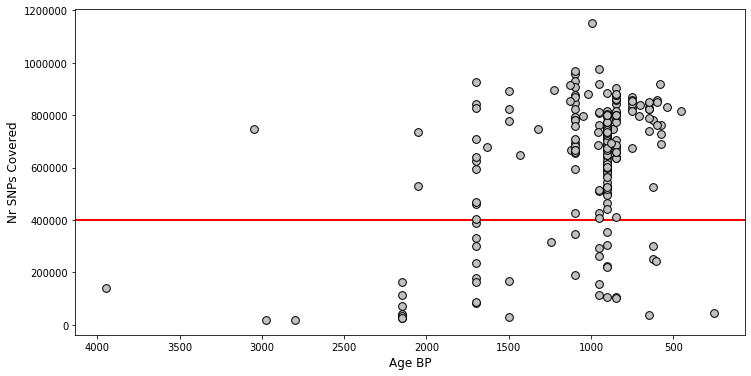

In [70]:
fs = 12
plt.figure(figsize=(12,6))
ax=plt.gca()
ax.scatter(x,y, ec="k", c="silver", s=60)
ax.invert_xaxis()
ax.set_xlabel("Age BP", fontsize=fs)
ax.set_ylabel("Nr SNPs Covered", fontsize=fs)
ax.axhline(y=400000, c="r", zorder=0, lw=2)
plt.show()

In [67]:
print(f"Nr of usable samples {np.sum(y>400000)} / {len(y)}")

Nr of usable samples 172 / 211


In [69]:
# Sample not in final Dataset
df_raw[~df_raw["iid"].isin(df_full["iid"])]

,iid,Master ID,age,age_range,Locality,Country,lat,lon,To_Use,clst,...,mtDNA match to consensus if ≥2 coverage (by library),batch notes (e.g. if a control well looks contaminated),"ASSESSMENT (Xcontam listed if |Z|>2 standard errors from zero: 0.02-0.05=""QUESTIONABLE"", >0.05=""QUESTIONABLE_CRITICAL"" or ""FAIL"") (mtcontam 97.5th percentile estimates listed if coverage >2: <0.8 is ""QUESTIONABLE_CRITICAL"", 0.8-0.95 is ""QUESTIONABLE"", and 0.95-0.98 is recorded but ""PASS"", gets overriden by ANGSD)",Famlst,Idlast,NewFamIst,NewIdlast,study,include_alt,mean_cov
37,S11170.Y1.E1.L1,I11170,3950,4000 BCE - 2000 CE,Canimar Abajo,Cuba,23.038894,-81.495252,"Yes (some, relative)",Cuba_unknown_1d17592_2d10756,...,"[0.882,0.96]",..,PASS,Cuba_unknown,NaN,NaN,NaN,Sirak20,1,0.117118


In [ ]:
df_full.sort_values(by="n_cov_snp", ascending=False)

In [ ]:
df_raw.columns